In [1]:
import pandas as pd
import geopandas
import json
import os
from shapely.geometry import Point
from shapely import wkt
import folium
import difflib
from geopy.distance import vincenty
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.ops import transform
from functools import partial
import pyproj

%matplotlib inline
inline_rc = dict(mpl.rcParams)

in_folder = "../data/"
out_folder = "audits/2018_07/images/"

In [2]:
osm_lines = pd.read_csv(os.path.join(in_folder, "osm-transit-extractor_lines.csv"), dtype=str)
osm_lines = osm_lines[osm_lines['mode'] == 'bus']

In [3]:
osm_line_route = pd.read_csv(os.path.join(in_folder, "osm-transit-extractor_line_routes.csv"), dtype=str)
tt = pd.DataFrame(osm_line_route.groupby('line_id').count()).reset_index()
tt.rename(columns={'route_id': 'nb_routes'}, inplace=True)
result = pd.merge(osm_lines,tt, on='line_id')

osm_lines = result[['line_id', 'name', 'nb_routes','code', 'colour', 'operator', 'network','shape']]

In [4]:
project = partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(init='EPSG:32633'))

def osm_shape_to_wkt(row):
    if pd.isna(row['shape']):
        wkt_ = wkt.loads('POINT (2.482068 49.0327237)')
    else :
        wkt_ = wkt.loads(row['shape'])
    return transform(project, wkt_) # on projette, pour avoir plus tard la longueur en mètres

osm_lines['geom'] = osm_lines.apply(osm_shape_to_wkt, axis=1)


/home/pclf/.local/share/virtualenvs/audit_routepoints-xp16w_6c/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


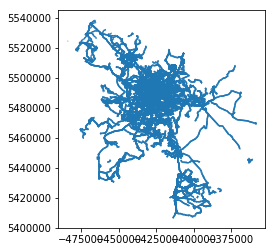

In [5]:
crs = {'init': 'epsg:4326'}
osm_lines_geo = geopandas.GeoDataFrame(osm_lines, crs=crs, geometry=osm_lines.geom)

osm_lines_geo.head()
osm_lines_geo.plot()

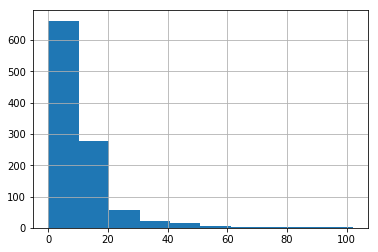

In [6]:
osm_lines_geo['line_length'] = (osm_lines_geo.length/osm_lines_geo['nb_routes'] ) /1000
osm_lines_geo['line_length'].hist()

In [14]:
osm_lines_geo_ok = osm_lines_geo[osm_lines_geo['line_length'] >= 3].copy()
#la ligne de bus Centaure fait 3,5 km 
#https://www.keolis-essonne-valdemarne.com/fileadmin/Sites/keolis_Seine_Essonne/Ligne_Keolis_Seine_Val-de-Marne_Centaure_04_vectorise.pdf

osm_lines_geo_ok[['line_id', 'name', 'network', 'line_length']]

tt = len(osm_lines_geo_ok) * 100.0 / len(osm_lines_geo)
"Pourcentage de lignes OSM qui ont un tracé : {}".format(tt)


## rapporté au nombre de lignes du GTFS
gtfs_lines = pd.read_csv(os.path.join(in_folder, "gtfs_routes.txt"), dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

tt = len(osm_lines_geo_ok) * 100.0 / len(gtfs_lines)
"Pourcentage de lignes qui ont un tracé : {}".format(tt)
len(gtfs_lines)

1436

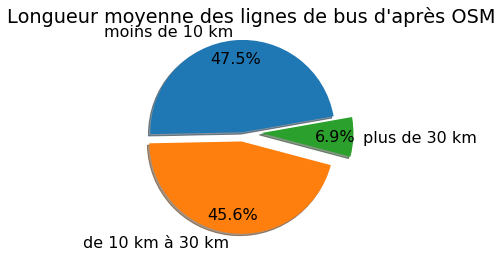

In [10]:
network_count = len(osm_lines_geo_ok)
labels = 'moins de 10 km', 'de 10 km à 30 km', 'plus de 30 km'
count_petit = len(osm_lines_geo_ok[osm_lines_geo_ok['line_length'] < 10])
count_moyen = len(osm_lines_geo_ok[(osm_lines_geo_ok['line_length'] >= 10) & (osm_lines_geo_ok['line_length'] < 30 )])
count_grand = len(osm_lines_geo_ok[osm_lines_geo_ok['line_length'] > 30])

sizes = [count_petit/network_count * 100, 
         count_moyen/network_count * 100,
         count_grand/network_count * 100]
explode = (0, 0.1, 0.2)

fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 16

ax1.set_title("Longueur moyenne des lignes de bus d'après OSM")
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10, pctdistance=0.8)
ax1.axis('equal') 
plt.savefig(os.path.join(out_folder,'21_longueur_moyenne_lignes.png'), bbox_inches='tight')

In [9]:
#difficile d'estimer la qualité du résultat, 
#mais si on regroupe par réseau, on retrouve bien les réseaux urbains vs les réseaux longues distances

osm_networks = pd.DataFrame(osm_lines_geo_ok.groupby('network').mean()).reset_index()

osm_networks.sort_values(by='line_length', ascending=False, inplace=True)
osm_networks.tail(10)
# petits réseaux urbains (Orgebus, Probus, Chavilbus)

osm_networks.head(10)
# réseaux en car type express (Express A14, Seine-et-Marne Express) 
# ou longue distance (Réseau Interurbain de Rambouillet, Le Bus Direct)

,network,nb_routes,line_length
27,Express A14,2.000000,81.989377
13,CEAT Sud Ile-de-France,4.000000,76.189846
35,Le Bus Direct,2.000000,54.484324
83,Seine-et-Marne Express,2.500000,51.885505
108,Étampois,2.000000,49.198076
28,Flixbus,2.000000,41.285935
86,Still,2.000000,34.646830
66,Réseau interurbain de Rambouillet,2.000000,34.263144
8,Bus Val d'Oise,2.666667,33.462282
73,STILL,2.416667,31.791413
